In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

# Prepare data

## Load dataset

In [2]:
#load dataset
df = pd.read_csv('./CSV/mental_illness_survey_1.csv', encoding='unicode-escape', low_memory=False)

In [3]:
#make a copy of dataframe for transformation
df1 = df.copy()

## Transform dataset

In [4]:
#drop unrequired columns
df1.drop(['Collector ID', 'Start Date', 'End Date', 'IP Address',
       'Email Address', 'First Name', 'Last Name', 'Custom Data 1', 'Device Type'],
        axis=1, inplace=True)

In [5]:
print('number of rows in dataset is: ', df1.shape[0])

number of rows in dataset is:  334


In [6]:
#check & clean duplicated
print('number of duplicates by respondent id is: ', df1[df1.duplicated(subset=['Respondent ID'], keep=False)].shape[0])

number of duplicates by respondent id is:  0


In [7]:
#rename columns for shorter name / easier for reading
df1.rename(columns={
    'Respondent ID':'respondent_id',
    'I identify as having a mental illness':'identified_mental_illness',
    'Education':'education',
    'I have my own computer separate from a smart phone':'computer_smart_phone_separted',
    'I have been hospitalized before for my mental illness':'been_hospitalised_before',
    'How many days were you hospitalized for your mental illness':'days_hospitalised',
    'I am currently employed at least part-time':'employed_atleast_parttime',
    'I am legally disabled':'legally_disabled',
    'I have my regular access to the internet':'internet_regular_access',
    'I live with my parents':'live_with_parents',
    'I have a gap in my resume':'gap_in_resume',
    'Total length of any gaps in my resume in months':'length_gap_in_resume',
    'Annual income (including any social welfare programs) in USD':'annual_income_total',
    'I am unemployed':'unemployed',
    'I read outside of work and school':'read_outside_work_school',
    'Annual income from social welfare programs':'annual_income_welfare',
    'I receive food stamps':'receive_food_stamps',
    'I am on section 8 housing':'on_section_8_housing',
    'How many times were you hospitalized for your mental illness':'times_hospitalised',
    'Lack of concentration':'symptom_lackofconcentration',
    'Anxiety':'symptom_anxiety',
    'Depression':'symptom_depression',
    'Obsessive thinking':'symptom_obsessivethinking',
    'Mood swings':'symptom_moodswings',
    'Panic attacks':'symptom_panicattacks',
    'Compulsive behavior':'symptom_compulsivebehaviour',
    'Tiredness':'symptom_tiredness',
    'Age':'age',
    'Gender':'gender',
    'Household Income':'household_income',
    'Region':'region' 
    }, inplace=True)

In [8]:
#count NaN in columns
df1.isnull().sum().sort_values(ascending=False)

symptom_compulsivebehaviour      305
symptom_moodswings               296
symptom_obsessivethinking        292
symptom_panicattacks             285
symptom_lackofconcentration      283
symptom_depression               248
symptom_anxiety                  234
symptom_tiredness                234
days_hospitalised                 37
region                             2
gap_in_resume                      0
education                          0
computer_smart_phone_separted      0
been_hospitalised_before           0
identified_mental_illness          0
employed_atleast_parttime          0
legally_disabled                   0
internet_regular_access            0
live_with_parents                  0
annual_income_welfare              0
length_gap_in_resume               0
annual_income_total                0
unemployed                         0
read_outside_work_school           0
household_income                   0
receive_food_stamps                0
on_section_8_housing               0
t

**Comments:**
> - NaN in `symptom_` columns means the respondent doesn't experience any of these symptoms.
> - NaN in `days_hospitalised` column accounts for approx. 1% of total rows in the dataset, with 32 'No' & 5 'Yes' identified with mental illness. Trial to build model by dropping these NaNs in the column.
> - NaN in `region` column only accounts for approx. 0.6% of total rows in the dataset. Drop these rows.

In [9]:
sympt_cols = ['symptom_lackofconcentration', 'symptom_anxiety',
       'symptom_depression', 'symptom_obsessivethinking', 'symptom_moodswings',
       'symptom_panicattacks', 'symptom_compulsivebehaviour',
       'symptom_tiredness']

#fill NaN `symptom_` columns with 0 and replace text in `symptom_` columns with 1
for sympt_col in sympt_cols:
    df1[sympt_col].fillna(0, axis=0, inplace=True)
    for text in df1[sympt_col]:
        if text != 0:
            df1[sympt_col].replace(text, 1, inplace=True)

In [10]:
#new df (df2) - drop 2 rows with NaN regions, drop 34 rows with NaN days_hospitalised
df2 = df1.dropna(subset=['region','days_hospitalised'])

In [11]:
#create dummy variables function
def create_dummy_df(df, cat_cols, dummy_na, drop_first):
    for col in cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=drop_first, dummy_na=dummy_na)], axis=1)
        except:
            continue
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''

    return df

In [12]:
#create dummy variables for categorical columns
df2_cat = df2.select_dtypes(include=['object'])

#pull a list of the column names of the categorical variables
cat2_cols_lst = df2_cat.columns


# Analyse, visualise & model

In [13]:
#apply create_dummy_df function to df_analyse
df2_analyse = create_dummy_df(df2, cat2_cols_lst, dummy_na=False, drop_first=False)

### Q1: What features have an influence on the likelihood of being identified having mental illness?
i.e.
- geographic
- gender & age
- education level
- income
- employment status
- support received
- health conditions
- lifestyle/behaviour

In [14]:
df2_analyse.columns

Index(['respondent_id', 'days_hospitalised', 'length_gap_in_resume',
       'annual_income_total', 'annual_income_welfare', 'times_hospitalised',
       'symptom_lackofconcentration', 'symptom_anxiety', 'symptom_depression',
       'symptom_obsessivethinking', 'symptom_moodswings',
       'symptom_panicattacks', 'symptom_compulsivebehaviour',
       'symptom_tiredness', 'identified_mental_illness_No',
       'identified_mental_illness_Yes', 'education_Completed Masters',
       'education_Completed Phd', 'education_Completed Undergraduate',
       'education_High School or GED', 'education_Some Masters',
       'education_Some Phd', 'education_Some Undergraduate',
       'education_Some highschool', 'computer_smart_phone_separted_No',
       'computer_smart_phone_separted_Yes', 'been_hospitalised_before_No',
       'been_hospitalised_before_Yes', 'employed_atleast_parttime_No',
       'employed_atleast_parttime_Yes', 'legally_disabled_No',
       'legally_disabled_Yes', 'internet_regul

In [15]:
#group features for easier interpretation
geo = df2_analyse[['region_East South Central', 'region_Middle Atlantic',
       'region_Mountain', 'region_New England', 'region_Pacific',
       'region_South Atlantic', 'region_West North Central',
       'region_West South Central','identified_mental_illness_Yes']]
gender_age = df2_analyse[['gender_Female', 'gender_Male','identified_mental_illness_Yes','age_18-29', 'age_30-44', 'age_45-60',
       'age_> 60']]
education = df2_analyse[['education_Completed Masters',
       'education_Completed Phd', 'education_Completed Undergraduate',
       'education_High School or GED', 'education_Some Masters',
       'education_Some Phd', 'education_Some Undergraduate',
       'education_Some highschool','identified_mental_illness_Yes']]
income = df2_analyse[['annual_income_total', 'household_income_$0-$9,999', 'household_income_$10,000-$24,999',
       'household_income_$100,000-$124,999',
       'household_income_$125,000-$149,999',
       'household_income_$150,000-$174,999',
       'household_income_$175,000-$199,999', 'household_income_$200,000+',
       'household_income_$25,000-$49,999', 'household_income_$50,000-$74,999',
       'household_income_$75,000-$99,999', 'household_income_Prefer not to answer','identified_mental_illness_Yes']]
employment =  df2_analyse[['length_gap_in_resume', 'employed_atleast_parttime_Yes','unemployed_Yes', 'identified_mental_illness_Yes']]
support = df2_analyse[['annual_income_welfare', 'live_with_parents_Yes', 'receive_food_stamps_Yes',
       'on_section_8_housing_Yes','identified_mental_illness_Yes']]
conditions = df2_analyse[['days_hospitalised', 'times_hospitalised', 'symptom_lackofconcentration', 'symptom_anxiety', 'symptom_depression',
       'symptom_obsessivethinking', 'symptom_moodswings',
       'symptom_panicattacks', 'symptom_compulsivebehaviour',
       'symptom_tiredness', 'been_hospitalised_before_Yes', 'legally_disabled_Yes', 'identified_mental_illness_Yes']]
behaviour = df2_analyse[['computer_smart_phone_separted_Yes', 'internet_regular_access_Yes', 'read_outside_work_school_Yes','identified_mental_illness_Yes']]

Text(0.5, 1, 'Lifestyle/behaviour features')

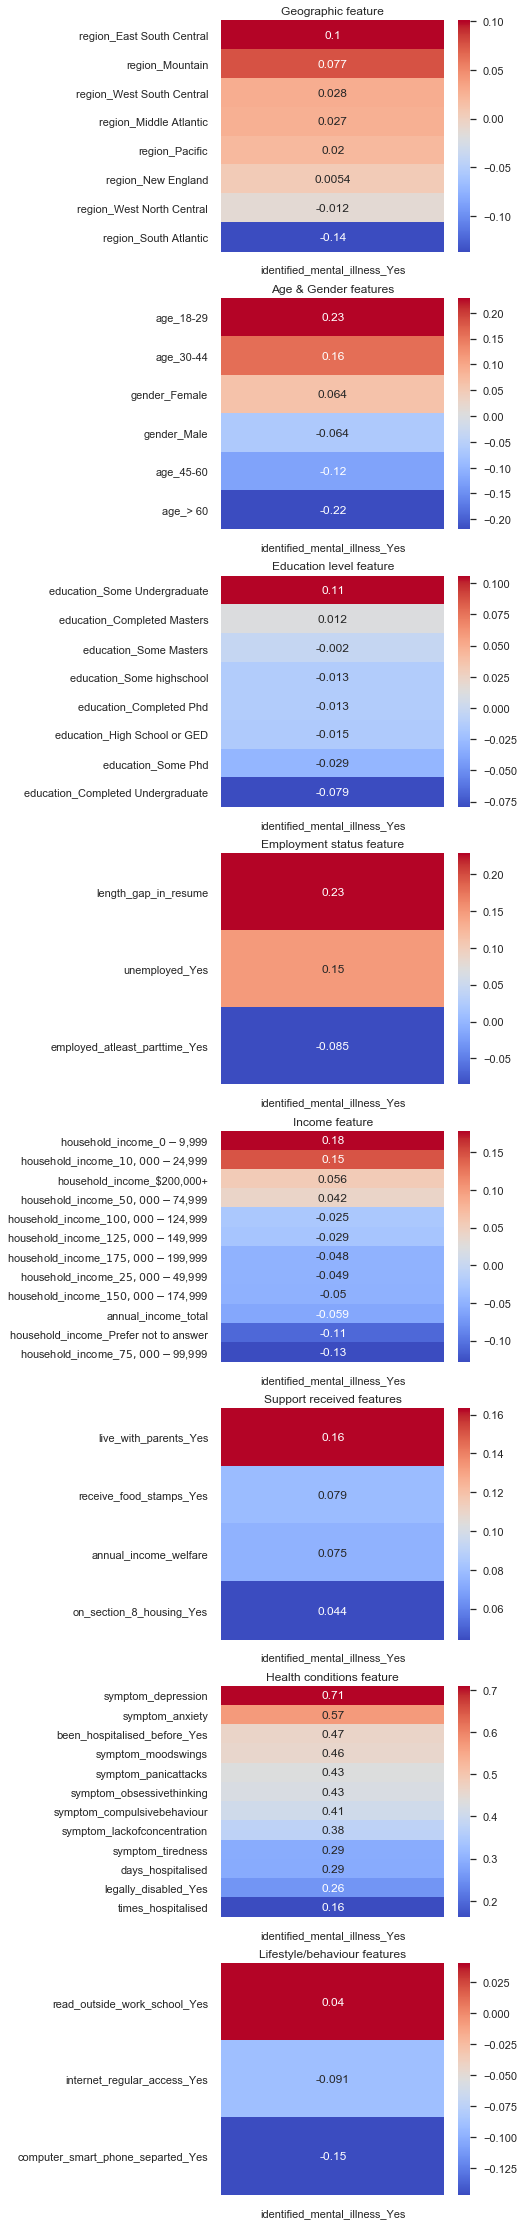

In [16]:
#plot correlation matrix
plt.figure(figsize = [5, 40])
sns.set(font_scale=1)

#geo
plt.subplot(8, 1, 1)
sns.heatmap(geo.corr()[['identified_mental_illness_Yes']].sort_values('identified_mental_illness_Yes', ascending=False)[1:],
            annot=True,
            cmap='coolwarm').set_title('Geographic feature')

#age & gender
plt.subplot(8, 1, 2)
sns.heatmap(gender_age.corr()[['identified_mental_illness_Yes']].sort_values('identified_mental_illness_Yes', ascending=False)[1:],
            annot=True,
            cmap='coolwarm').set_title('Age & Gender features')

#education
plt.subplot(8, 1, 3)
sns.heatmap(education.corr()[['identified_mental_illness_Yes']].sort_values('identified_mental_illness_Yes', ascending=False)[1:],
            annot=True,
            cmap='coolwarm').set_title('Education level feature')


#employment
plt.subplot(8, 1, 4)
sns.heatmap(employment.corr()[['identified_mental_illness_Yes']].sort_values('identified_mental_illness_Yes', ascending=False)[1:],
            annot=True,
            cmap='coolwarm').set_title('Employment status feature')

#income
plt.subplot(8, 1, 5)
sns.heatmap(income.corr()[['identified_mental_illness_Yes']].sort_values('identified_mental_illness_Yes', ascending=False)[1:],
            annot=True,
            cmap='coolwarm').set_title('Income feature')

#support
plt.subplot(8, 1, 6)
sns.heatmap(support.corr()[['identified_mental_illness_Yes']].sort_values('identified_mental_illness_Yes', ascending=False)[1:],
            annot=True,
            cmap='coolwarm').set_title('Support received features')

#conditions
plt.subplot(8, 1, 7)
sns.heatmap(conditions.corr()[['identified_mental_illness_Yes']].sort_values('identified_mental_illness_Yes', ascending=False)[1:],
            annot=True,
            cmap='coolwarm').set_title('Health conditions feature')

#behavior
plt.subplot(8, 1, 8)
sns.heatmap(behaviour.corr()[['identified_mental_illness_Yes']].sort_values('identified_mental_illness_Yes', ascending=False)[1:],
            annot=True,
            cmap='coolwarm').set_title('Lifestyle/behaviour features')

**Comments:** As the above correlation heatmap shows:<br/>
- Employment status, age and health conditions features have quite high correlation relationship with experiencing mental illness
- While other features like geographic, demographic and behavioural only have a moderate level of correlation relationship.

Which means that being able to find job (at least part-time) have a positive impact on one's mental wellbeing. The longer the time one is being unemployed, the higher the chance they will be experiencing mental illness. Additionally, younger people are more likely not being able to handle stress in life which potentially results in higher rate of experiencing mental illness.

Interestingly, having higher or lower education level doesn't seem to have much impact on being identified as mental illness neither. The assumption people with higher level of education (i.e. master compared to high school) would have higher self-expectation to achieve more in life, which might lure them to experience more stress.

### Q2: 

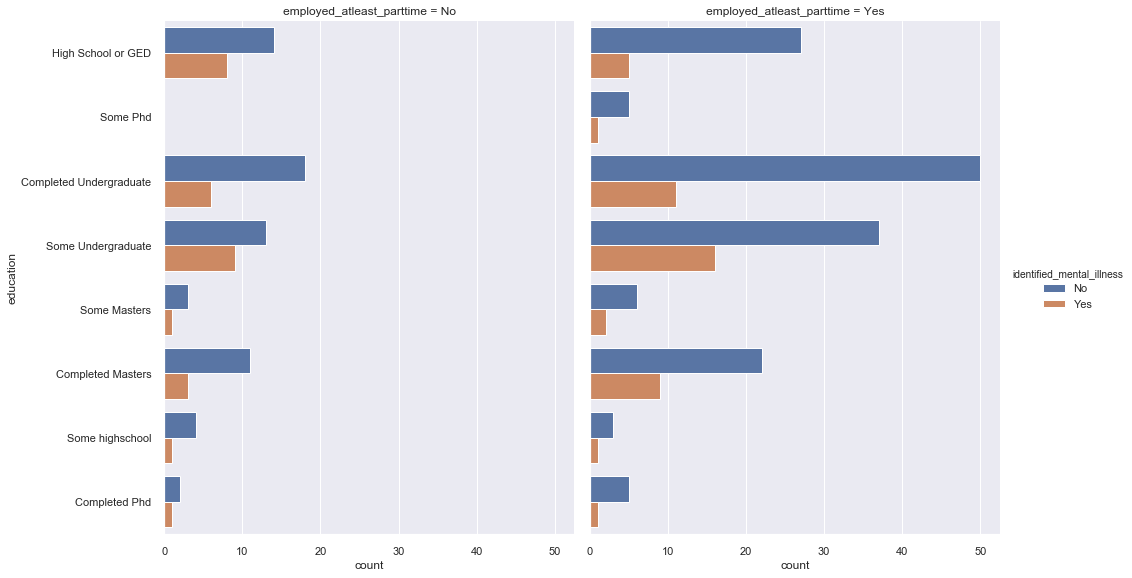

In [17]:
#mental illness by education & employment status
age_employmentpt = sns.catplot(y="education", hue="identified_mental_illness", col="employed_atleast_parttime",
                data=df2, kind="count",
                height=8, aspect=.9);

**Comments:**
- Peple with some undergrad or completed undergrad, in general, have the highest chance of being identified with mental illness than people in other groups by education level.
- Interestingly, people with high school or general education have lower chance of experience mental illness than people completed masters if they're employed at least part-time. 

The above 2 observations can be explained by the assumption that people have a minimum undergrad qualification have higher expectation to career success. This potentially creates more pressure in their life, negatively impacting their mental health being. Whereas, people who have lower level of education - highschool or general education, having at least a part-time job to make a living is good enough for them not to be stressful.

In overall, being employed at least part-time reduces the proportion of people experiencing mental illness, regardless of their education level. We can see this insight from a significant lower amount of people being identified with mental illness and not - the gap between these 2 groups from the 2 charts above.

Text(0.5, 1.0, 'Not identified with mental illness')

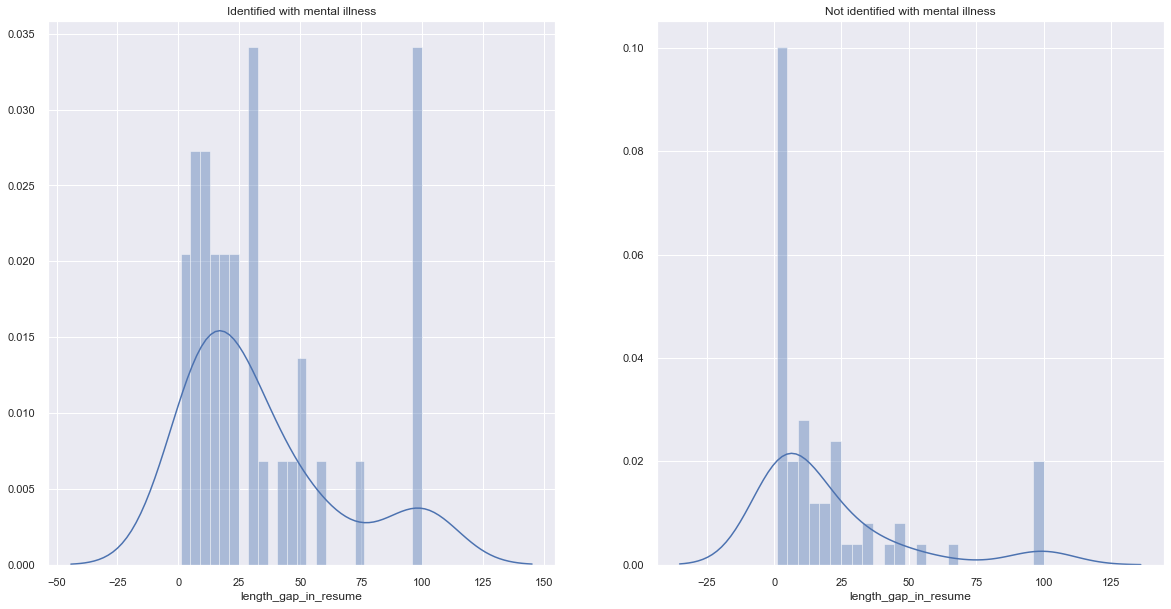

In [18]:
#mental illness with at least 1 month gap in resume

#data subset
df2_resumegap_ill = df2.loc[(df2['identified_mental_illness'] == 'Yes') & (df2['length_gap_in_resume'] > 0)]['length_gap_in_resume']
df2_resumegap_notill = df2.loc[(df2['identified_mental_illness'] == 'No') & (df2['length_gap_in_resume'] > 0)]['length_gap_in_resume']

#plot correlation matrix
plt.figure(figsize = [20, 10])
sns.set(font_scale=1)

#length of gap in resume, identified with mental illness
plt.subplot(1, 2, 1)
sns.distplot(df2_resumegap_ill, bins=25).set_title('Identified with mental illness')

#length of gap in resume, identified with mental illness
plt.subplot(1, 2, 2)
sns.distplot(df2_resumegap_notill, bins=25).set_title('Not identified with mental illness')



**Comments:** 
- People were identified with mental illness are more likely to have bigger gap in their resume than people without mental illness

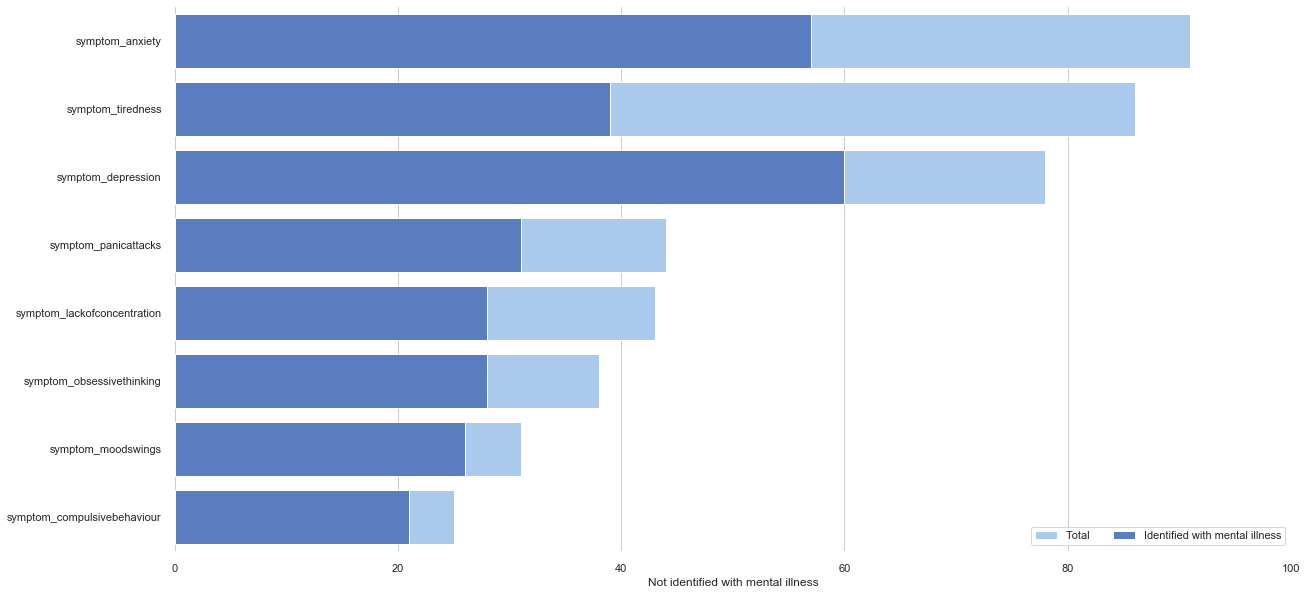

In [19]:
#plot symptoms, people with and without mental illness

#df of people identified with mental illness
df2_mentalill_yes = df2.loc[df2['identified_mental_illness'] == 'Yes']
symptoms_ill_yes = df2_mentalill_yes[['symptom_lackofconcentration', 'symptom_anxiety',
       'symptom_depression', 'symptom_obsessivethinking', 'symptom_moodswings',
       'symptom_panicattacks', 'symptom_compulsivebehaviour',
       'symptom_tiredness']]
symptoms_ill_yes = pd.DataFrame(symptoms_ill_yes.sum()).reset_index()
symptoms_ill_yes.rename(columns={'index':'symptom', 0:'identified_with_mental_illness'}, inplace=True)


#df of people not identified with mental illness
df2_mentalill_no = df2.loc[df2['identified_mental_illness'] == 'No']
symptoms_ill_no = df2_mentalill_no[['symptom_lackofconcentration', 'symptom_anxiety',
       'symptom_depression', 'symptom_obsessivethinking', 'symptom_moodswings',
       'symptom_panicattacks', 'symptom_compulsivebehaviour',
       'symptom_tiredness']]
symptoms_ill_no = pd.DataFrame(symptoms_ill_no.sum()).reset_index()
symptoms_ill_no.rename(columns={'index':'symptom', 0:'not_identified_with_mental_illness'}, inplace=True)

#merge the above 2 dfs to 1 df
symptoms_by_ill = pd.merge(symptoms_ill_yes, symptoms_ill_no, on='symptom')

#create a new column 'total' = 'identified_with_mental_illness' + 'not_identified_with_mental_illness'
symptoms_by_ill['total'] = symptoms_by_ill['identified_with_mental_illness'] + symptoms_by_ill['not_identified_with_mental_illness']

sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(20, 10))

# Load the dataset
symptoms_by_ill = symptoms_by_ill.sort_values("total", ascending=False)

# Plot the total observation of each symptom
sns.set_color_codes("pastel")
sns.barplot(x="total", y="symptom", data=symptoms_by_ill,
            label="Total", color="b")

# Plot the symptoms where people identified with mental illness
sns.set_color_codes("muted")
sns.barplot(x="identified_with_mental_illness", y="symptom", data=symptoms_by_ill,
            label="Identified with mental illness", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 100), ylabel="",
       xlabel="Not identified with mental illness")
sns.despine(left=True, bottom=True)

**Comments:**
- People who are identified with mental illness are very likely to experience anxiety and depression.
- Other symptoms such as compulsive behaviour, moodswings, panic attacks, lack of concentration, and obsessive thinking are more likely be observed in people with mental illness than people without mental illness, however these symptoms are less dominance than anxiety and depression.
- Tiredness are common mental welling issue, which also happen to people without mental illness still have high chance of experience it.

## Q3: Based on what we analysed above, we have an idea of the potential set of questions we should ask to gather data used for a logistic regression model predicting if a person is likely experiencing mental illness

In [20]:
#apply create_dummy_df function to df_model
df2_model = create_dummy_df(df2, cat2_cols_lst, dummy_na=False, drop_first=True)

In [21]:
#selecting features that have moderate level of correlation to output variable (identified_with_mental_illness)
#manually remove features that we think have a level of co-correlation
df2_model = df2_model[['length_gap_in_resume', 'symptom_lackofconcentration', 'symptom_anxiety', 'symptom_depression',
       'symptom_obsessivethinking', 'symptom_moodswings',
       'symptom_panicattacks', 'symptom_compulsivebehaviour',
       'symptom_tiredness', 'identified_mental_illness_Yes', 'education_Completed Phd', 'education_Completed Undergraduate',
       'education_High School or GED', 'education_Some Masters',
       'education_Some Phd', 'education_Some Undergraduate',
       'education_Some highschool', 'computer_smart_phone_separted_Yes', 'read_outside_work_school_Yes', 'internet_regular_access_Yes',
       'live_with_parents_Yes', 'age_30-44', 'age_45-60', 'age_> 60',
       'gender_Male', 'household_income_$10,000-$24,999',
       'household_income_$100,000-$124,999',
       'household_income_$125,000-$149,999',
       'household_income_$150,000-$174,999',
       'household_income_$175,000-$199,999', 'household_income_$200,000+',
       'household_income_$25,000-$49,999', 'household_income_$50,000-$74,999',
       'household_income_$75,000-$99,999',
       'household_income_Prefer not to answer', 'region_East South Central',
       'region_Middle Atlantic', 'region_Mountain', 'region_New England',
       'region_Pacific', 'region_South Atlantic', 'region_West North Central',
       'region_West South Central']]

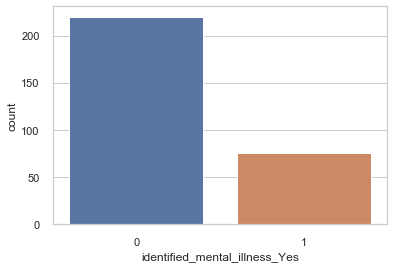

In [22]:
#overview of output variable
df2_model.identified_mental_illness_Yes.value_counts()
sns.countplot(x='identified_mental_illness_Yes', data=df2_model)
plt.show()

In [23]:
#create X & y variables
X = df2_model[['length_gap_in_resume', 'symptom_lackofconcentration', 'symptom_anxiety', 'symptom_depression',
       'symptom_obsessivethinking', 'symptom_moodswings',
       'symptom_panicattacks', 'symptom_compulsivebehaviour',
       'symptom_tiredness', 'education_Completed Phd', 'education_Completed Undergraduate',
       'education_High School or GED', 'education_Some Masters',
       'education_Some Phd', 'education_Some Undergraduate',
       'education_Some highschool', 'computer_smart_phone_separted_Yes', 'read_outside_work_school_Yes', 'internet_regular_access_Yes',
       'live_with_parents_Yes', 'age_30-44', 'age_45-60', 'age_> 60',
       'gender_Male', 'household_income_$10,000-$24,999',
       'household_income_$100,000-$124,999',
       'household_income_$125,000-$149,999',
       'household_income_$150,000-$174,999',
       'household_income_$175,000-$199,999', 'household_income_$200,000+',
       'household_income_$25,000-$49,999', 'household_income_$50,000-$74,999',
       'household_income_$75,000-$99,999',
       'household_income_Prefer not to answer', 'region_East South Central',
       'region_Middle Atlantic', 'region_Mountain', 'region_New England',
       'region_Pacific', 'region_South Atlantic', 'region_West North Central',
       'region_West South Central']]
y = df2_model['identified_mental_illness_Yes']


In [24]:
#create train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=0)

In [25]:
#instantiate & fit logistic regression model
logit_model = LogisticRegression()
logit_model.fit(X_train, y_train)

c:\users\sandy\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [26]:
#predict X_test using logistic regression model
y_pred = logit_model.predict(X_test)

In [27]:
#evaluate logistic regression model using confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[104,  12],
       [  9,  23]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

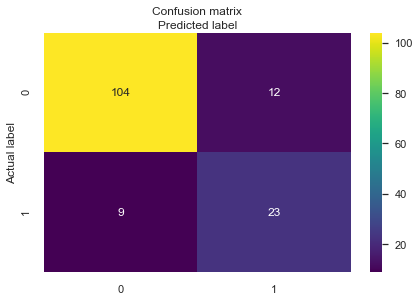

In [28]:
#plot confusion matrix
class_names = [0, 1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="viridis" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Accuracy package: 0.8581081081081081
Precision package: 0.6571428571428571
Recall package: 0.71875


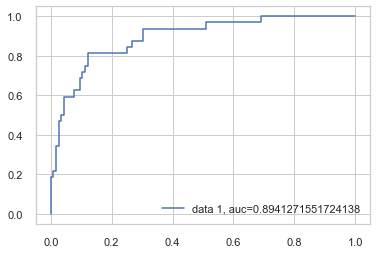

auc (area under curve) is:  0.8941271551724138


In [29]:
#caculating accuracy, recall and precision metrics

TP = cnf_matrix[1][1]
TN = cnf_matrix[0][0]
FP = cnf_matrix[1][0]
FN = cnf_matrix[0][1]

print("Accuracy package:", metrics.accuracy_score(y_test, y_pred))
print("Precision package:", metrics.precision_score(y_test, y_pred))
print("Recall package:", metrics.recall_score(y_test, y_pred))

#Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate(Recall) against the false positive rate.
#It shows the tradeoff between sensitivity and specificity.

y_pred_proba = logit_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

print('auc (area under curve) is: ', str(auc))

**Comments:** with auc = 0.8941, there is approx 89.41% chance that our model will be able to distinguish between correctly who are likely to be identified having mental illness based on the below variables:
1. the gap in their resume (in months)
2. any symptoms they have such as lackofconcentration, anxiety, depression, tiredness etc
3. their education level
4. age & gender
5. household income
6. region
7. if they live with their parents
8. if they're reading outside of work / school
9. if they have regular access to internet
10. if they have computer and smart phone use separately


To avoid including variables that relate to each other, which will decrease the effectiveness of our logistic regression model, you can see that:
- in term of employment status, we only include length of gap in resume, and exclude unemployment and employed at least part time variables. This is because these 3 variables are closely related to each other, and I only include the length of gap in resume due to its higher correlation relationship with our output variable.
- in term of income, we only include household income, and exclude total income with or without welfare contribution.
- we also did not include variables that have obvious strong relationship with our output variables (i.e. being hospitalised before, times / days hospitalised, legally disable, receiving support from government - welfare and on section 8 housing etc). This is because our purpose of our model is to predict the likelyhood of a person being identified with mental illness, which in real life we wont be able to gather these data because assuming they're not yet identified with mental illness).


